# CEST 2025 : Code of the paper entitled "Forest Resilience, Precipitation, and Ecosystem Service Value: A Correlation and Trend Analysis"

The code presented hereafter includes:
- the processing and analysis of  Ecosystem Service Valuation (ESV) data &  Annual to Monthly Interpolation;
- the computation of  the statistical comparison for the three interpolation methods;
- the selection of the best method to estimate the monthly data;
- the correlation analysis between the Variables (KNDVI+Precipitation+ESV), for each continent and  the correlation for specific biomes
- the prediction of ESV values over time using various ML techniques (Random Forest, XGBoost, ensembling)

@ Authors: Pius Nwachukwu & Laure Berti-Equille

In [1]:
#Install all the required libraries in your environment
#!pip3 install eemont wxee earthengine-api geopandas pandas numpy scikit-learn ace-tools matplotlib seaborn setuptools
#Download the datasets from https://drive.google.com/drive/folders/1Ape1onmoq5CdOHzkXTy--doM5jCacA9U?usp=sharing


In [2]:
import ee, eemont, wxee

/Users/laureberti/Git/CEST_2025/.cest_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [132]:
# Authenticate and initialize the Earth Engine module.
ee.Authenticate()
ee.Initialize(project='xxxx')

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████| 568k/568k [00:01<00:00, 542kiB/s]


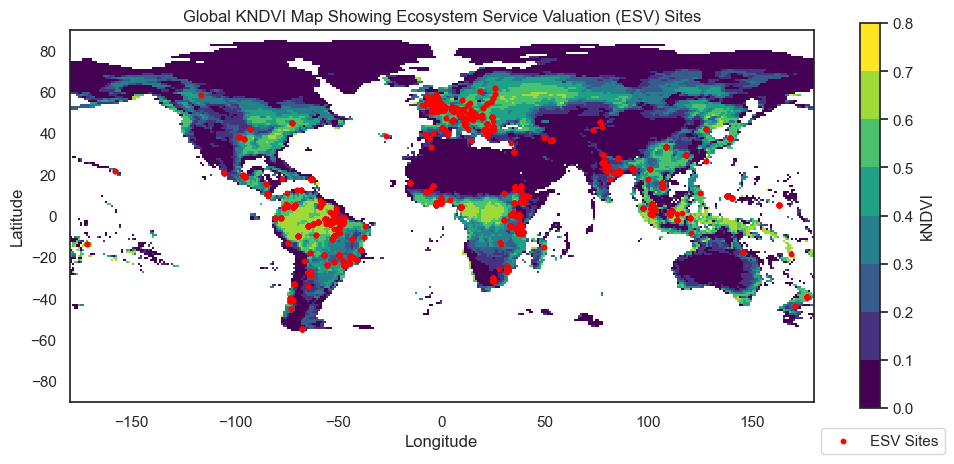

In [134]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Get the first image from the ImageCollection 
MOD_collection = ee.ImageCollection("MODIS/006/MCD43A4").filterDate("2021-06-01","2021-08-02").scaleAndOffset().spectralIndices("kNDVI") 

single_image_ee = MOD_collection.first()



# Step 1: Load the CSV data and convert it to a GeoDataFrame
file_path = 'Esvd_Full_Data_Version_MAY2023V1.1.csv'
esvd_data = pd.read_csv(file_path)

# Assuming the CSV has 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(esvd_data['Longitude'], esvd_data['Latitude'])]
esvd_gdf = gpd.GeoDataFrame(esvd_data, geometry=geometry)

# Step 2: Convert the single Earth Engine image to an xarray Dataset

single_image_xarray = single_image_ee.wx.to_xarray(region=ee.Geometry.BBox(-180, -90, 180, 90))


# Step 4: Plot the kNDVI
fig, ax = plt.subplots(figsize=(12, 5))
single_image_xarray.kNDVI.plot(
    ax=ax,
    cmap="viridis",
    levels=10,
    # vmin=0,
    # vmax=1,
)

# Step 5: Add the shapefile overlay
esvd_gdf.plot(ax=ax, color='red', markersize=10, label='ESV Sites')

# Step 6: Customize the plot
ax.set_title("Global KNDVI Map Showing Ecosystem Service Valuation (ESV) Sites")
ax.set_xlabel("Longitude")  # Label for the x-axis
ax.set_ylabel("Latitude")   # Label for the y-axis
ax.legend(loc='upper left', bbox_to_anchor=(1, -0.05), ncol=6)

plt.show()

# Step 1. Process the dates & Perform Annual to Monthly Interpolation

In [6]:
# Complete Code of the 3 Methods of Estimation

import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Load the ESV dataset
esv_file_path = "Esvd_Full_Data_Version_MAY2023V1.1.csv"
esv_df = pd.read_csv(esv_file_path)

# Keep only necessary columns
esv_df = esv_df[['Continent', 'ESVD2.0_Biome', 'Year_Pub', 'Int$ Per Hectare Per Year']]

# Rename Year column for consistency
esv_df.rename(columns={'Year_Pub': 'year'}, inplace=True)

# Ensure year is numeric
esv_df['year'] = pd.to_numeric(esv_df['year'], errors='coerce')

# Filter for records from 2000 onwards
esv_df = esv_df[esv_df['year'] >= 2000]

# Handle missing values using forward and backward fill within each Continent & Biome group
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby(['Continent', 'ESVD2.0_Biome'])['Int$ Per Hectare Per Year'].ffill()
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby(['Continent', 'ESVD2.0_Biome'])['Int$ Per Hectare Per Year'].bfill()

# Fill any remaining NaNs with the median value for each Continent
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby('Continent')['Int$ Per Hectare Per Year'].transform(lambda x: x.fillna(x.median()))

# Aggregate duplicate years by computing the mean ESV value
esv_df = esv_df.groupby(['Continent', 'ESVD2.0_Biome', 'year'], as_index=False).agg({
    'Int$ Per Hectare Per Year': 'mean'
})

# Function to generate monthly ESV estimates using linear interpolation
def create_monthly_esv_linear(df):
    monthly_records = []
    for _, row in df.iterrows():
        for month in range(1, 13):  # Create 12 months per year
            monthly_records.append({
                'Continent': row['Continent'],
                'year': row['year'],
                'month': month,
                'ESVD2.0_Biome': row['ESVD2.0_Biome'],
                'Int$ Per Hectare Per Year': row['Int$ Per Hectare Per Year'] / 12  # Evenly distribute
            })
    return pd.DataFrame(monthly_records)

# Generate monthly estimates using linear interpolation
esv_monthly_linear = create_monthly_esv_linear(esv_df)

# Function to generate monthly ESV estimates using spline interpolation
def create_monthly_esv_spline(df):
    monthly_records = []
    grouped = df.groupby(['Continent', 'ESVD2.0_Biome'])

    for (continent, biome), group in grouped:
        group = group.sort_values(by='year')  # Ensure years are increasing
        years = group['year'].values
        esv_values = group['Int$ Per Hectare Per Year'].values

        if len(years) < 2:
            continue  # Skip if there's only one year of data

        spline = CubicSpline(years, esv_values, bc_type='natural')

        for year in range(years.min(), years.max() + 1):
            for month in range(1, 13):
                monthly_esv = spline(year) / 12  # Distribute yearly estimate over 12 months
                monthly_records.append({
                    'Continent': continent,
                    'year': year,
                    'month': month,
                    'ESVD2.0_Biome': biome,
                    'Int$ Per Hectare Per Year': monthly_esv
                })

    return pd.DataFrame(monthly_records)

# Generate monthly estimates using spline interpolation
esv_monthly_spline = create_monthly_esv_spline(esv_df)

# Function to generate monthly ESV estimates using rolling mean
def create_monthly_esv_rolling(df, window=3):
    monthly_records = []
    grouped = df.groupby(['Continent', 'ESVD2.0_Biome'])

    for (continent, biome), group in grouped:
        group = group.sort_values(by='year')
        group['Rolling_ESV'] = group['Int$ Per Hectare Per Year'].rolling(window=window, min_periods=1, center=True).mean()

        for _, row in group.iterrows():
            for month in range(1, 13):
                monthly_records.append({
                    'Continent': row['Continent'],
                    'year': row['year'],
                    'month': month,
                    'ESVD2.0_Biome': row['ESVD2.0_Biome'],
                    'Int$ Per Hectare Per Year': row['Rolling_ESV'] / 12  # Distribute yearly estimate over 12 months
                })

    return pd.DataFrame(monthly_records)

# Generate monthly estimates using rolling mean
esv_monthly_rolling = create_monthly_esv_rolling(esv_df)

# Display first few rows of each method
esv_monthly_linear.head(), esv_monthly_spline.head(), esv_monthly_rolling.head()


(  Continent  year  month                             ESVD2.0_Biome  \
 0    Africa  2011      1  Boreal and montane forests and woodlands   
 1    Africa  2011      2  Boreal and montane forests and woodlands   
 2    Africa  2011      3  Boreal and montane forests and woodlands   
 3    Africa  2011      4  Boreal and montane forests and woodlands   
 4    Africa  2011      5  Boreal and montane forests and woodlands   
 
    Int$ Per Hectare Per Year  
 0                  14.458935  
 1                  14.458935  
 2                  14.458935  
 3                  14.458935  
 4                  14.458935  ,
   Continent  year  month       ESVD2.0_Biome  Int$ Per Hectare Per Year
 0    Africa  2015      1  Intensive land use                   6.331667
 1    Africa  2015      2  Intensive land use                   6.331667
 2    Africa  2015      3  Intensive land use                   6.331667
 3    Africa  2015      4  Intensive land use                   6.331667
 4    Africa  

In [7]:
# # Save the Monthly Estimates


# # Define file paths for saving the datasets
linear_interpolation_path = "esv_monthly_linear.csv"
spline_interpolation_path = "esv_monthly_spline.csv"
rolling_mean_path = "esv_monthly_rolling.csv"

# # Save the datasets to CSV files
esv_monthly_linear.to_csv(linear_interpolation_path, index=False)
esv_monthly_spline.to_csv(spline_interpolation_path, index=False)
esv_monthly_rolling.to_csv(rolling_mean_path, index=False)

# # Provide download links
# linear_interpolation_path, spline_interpolation_path, rolling_mean_path


In [8]:
# Get the statistics

import pandas as pd

# Load the saved datasets
linear_df = pd.read_csv("esv_monthly_linear.csv")
spline_df = pd.read_csv("esv_monthly_spline.csv")
rolling_df = pd.read_csv("esv_monthly_rolling.csv")

# Perform statistical analysis
linear_stats = linear_df["Int$ Per Hectare Per Year"].describe()
spline_stats = spline_df["Int$ Per Hectare Per Year"].describe()
rolling_stats = rolling_df["Int$ Per Hectare Per Year"].describe()

# Combine results into a single dataframe for comparison
stats_comparison = pd.DataFrame({
    "Linear Interpolation": linear_stats,
    "Spline Interpolation": spline_stats,
    "Rolling Mean": rolling_stats
})

# Display the results
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Statistical Analysis of Monthly ESV Estimates", dataframe=stats_comparison)

print("Statistical Analysis of Monthly ESV Estimates:")
print(stats_comparison)


Statistical Analysis of Monthly ESV Estimates:
       Linear Interpolation  Spline Interpolation  Rolling Mean
count           2832.000000           4200.000000   2832.000000
mean             395.434030            241.932974    381.637395
std             2410.419216           1577.252968   1877.237074
min                0.000142           -514.861107      0.004723
25%                2.819805              3.423533      7.127671
50%               17.841727             34.227990     28.868600
75%               72.538347            106.050229     91.569536
max            22644.726761          22042.198322  22644.726761


# Step 2. Compute the statistical comparison for the three interpolation methods
Based on the following metrics:
    Mean Absolute Error (MAE) – Measures the average absolute difference between estimated and original values.
    Root Mean Square Error (RMSE) – Penalizes larger errors more than MAE.
    Pearson Correlation – Measures the linear relationship between interpolated and original ESV values.
    Spearman Correlation – Measures monotonic relationships (useful if data is not normally distributed).
    Standard Deviation (STD) – Checks if the variability in estimated monthly values matches the original yearly data.

In [9]:
# Step 2: Compute Statistical Comparison for the Three Interpolation Methods
# Now, we compare the mean, median, standard deviation, and range of the three methods.

# Compute summary statistics for each method
linear_stats = esv_monthly_linear['Int$ Per Hectare Per Year'].describe()
spline_stats = esv_monthly_spline['Int$ Per Hectare Per Year'].describe()
rolling_stats = esv_monthly_rolling['Int$ Per Hectare Per Year'].describe()

# Combine into a single DataFrame
stats_comparison = pd.DataFrame({
    'Linear Interpolation': linear_stats,
    'Spline Interpolation': spline_stats,
    'Rolling Mean': rolling_stats
})

# Display the statistical comparison
print(stats_comparison)



       Linear Interpolation  Spline Interpolation  Rolling Mean
count           2832.000000           4200.000000   2832.000000
mean             395.434030            241.932974    381.637395
std             2410.419216           1577.252968   1877.237074
min                0.000142           -514.861107      0.004723
25%                2.819805              3.423533      7.127671
50%               17.841727             34.227990     28.868600
75%               72.538347            106.050229     91.569536
max            22644.726761          22042.198322  22644.726761


In [10]:
# Pearson's R (Comparison of the Monthly Estimation Methods)
import numpy as np
import pandas as pd
from scipy.stats import pearsonr  # Import Pearson correlation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to compute statistical metrics
def compute_statistics(true_annual, estimated_monthly, method_name):
    """
    Compute MAE, RMSE, Pearson Correlation, and STD for the estimated monthly ESV values.

    Parameters:
        true_annual (pd.DataFrame): The original annual ESV dataset.
        estimated_monthly (pd.DataFrame): The monthly estimated ESV dataset.
        method_name (str): Name of the interpolation method.

    Returns:
        dict: A dictionary with statistical metrics.
    """

    # Aggregate monthly estimates to annual for comparison
    estimated_annual = estimated_monthly.groupby(['Continent', 'year'])['Int$ Per Hectare Per Year'].sum().reset_index()

    # Merge with true annual data
    merged_df = pd.merge(true_annual, estimated_annual, on=['Continent', 'year'], suffixes=('_true', '_pred'))

    # Compute statistical metrics
    mae = mean_absolute_error(merged_df['Int$ Per Hectare Per Year_true'], merged_df['Int$ Per Hectare Per Year_pred'])
    rmse = np.sqrt(mean_squared_error(merged_df['Int$ Per Hectare Per Year_true'], merged_df['Int$ Per Hectare Per Year_pred']))
    pearson_corr, _ = pearsonr(merged_df['Int$ Per Hectare Per Year_true'], merged_df['Int$ Per Hectare Per Year_pred'])  # Using Pearson correlation
    std = np.std(merged_df['Int$ Per Hectare Per Year_pred'])

    # Return results as a dictionary
    return {
        "Method": method_name,
        "MAE": mae,
        "RMSE": rmse,
        "Pearson Correlation": pearson_corr,  # Use Pearson correlation
        "STD": std
    }

# Compute statistics for each method
linear_stats = compute_statistics(esv_df, esv_monthly_linear, "Linear Interpolation")
spline_stats = compute_statistics(esv_df, esv_monthly_spline, "Spline Interpolation")
rolling_stats = compute_statistics(esv_df, esv_monthly_rolling, "Rolling Mean")

# Combine results into a DataFrame for easy visualization
stats_df = pd.DataFrame([linear_stats, spline_stats, rolling_stats])

# Display the results
print(stats_df)


                 Method           MAE          RMSE  Pearson Correlation  \
0  Linear Interpolation  19955.794561  66548.328650             0.393928   
1  Spline Interpolation  18329.119684  59310.913014             0.269501   
2          Rolling Mean  19722.220445  58671.358228             0.353197   

            STD  
0  69045.387263  
1  58024.904846  
2  59390.823534  


# Step 3. Then Use the Best Method to Estimate the Monthly Data

In [19]:

# Re-load necessary packages after execution state reset

from scipy.interpolate import CubicSpline

# Load the dataset
esv_file_path = "Esvd_Full_Data_Version_MAY2023V1.1.csv"
esv_df = pd.read_csv(esv_file_path)

# Rename the Year column for consistency
esv_df.rename(columns={'Year_Pub': 'year'}, inplace=True)

# Ensure year is numeric and filter data from 2000 onwards
esv_df['year'] = pd.to_numeric(esv_df['year'], errors='coerce')
esv_df = esv_df[esv_df['year'] >= 2000]

# Keep only relevant columns
esv_df = esv_df[['Continent', 'ESVD2.0_Biome', 'year', 'Int$ Per Hectare Per Year']]

# Fill missing values using the median for each Continent
esv_df['Int$ Per Hectare Per Year'] = esv_df.groupby('Continent')['Int$ Per Hectare Per Year'].transform(lambda x: x.fillna(x.median()))

from datetime import datetime
# Function to expand annual data into monthly records
def create_monthly_esv(df):
    monthly_records = []
    for _, row in df.iterrows():
        for month in range(1, 13):  # Create 12 months per year
            monthly_records.append({
                'Continent': row['Continent'],
                'year': row['year'],
                'month': month,
                'ESVD2.0_Biome': row['ESVD2.0_Biome'],
                'Int$ Per Hectare Per Year': row['Int$ Per Hectare Per Year'] / 12,  # Evenly distribute across months
                'date': pd.to_datetime(datetime(row['year'],month, 1), format="%YYYY-%MM-%d")  # YYYY-MM-01 format
            })
    return pd.DataFrame(monthly_records)

# Generate the monthly dataset
esv_monthly_df = create_monthly_esv(esv_df)

# Convert year and month to a datetime format
esv_monthly_df['date'] = pd.to_datetime(esv_monthly_df['year'].astype(str) + '-' + esv_monthly_df['month'].astype(str) + '-01')

# Display summary statistics
print("Summary Statistics:\n", esv_monthly_df.describe())

# Check if there are any missing values
print("Missing Values After Transformation:\n", esv_monthly_df.isnull().sum())

# Display first few rows to confirm transformation
print(esv_monthly_df.head())


Summary Statistics:
                year         month  Int$ Per Hectare Per Year  \
count  32448.000000  32448.000000               32448.000000   
mean    2014.372781      6.500000                 684.742780   
min     2000.000000      1.000000                   0.000000   
25%     2011.000000      3.750000                   1.675221   
50%     2016.000000      6.500000                   5.498800   
75%     2019.000000      9.250000                  26.845838   
max     2022.000000     12.000000              165725.675658   
std        5.914553      3.452106                5829.901081   

                                date  
count                          32448  
mean   2014-10-30 17:22:16.686390528  
min              2000-01-01 00:00:00  
25%              2011-04-01 00:00:00  
50%              2016-07-01 00:00:00  
75%              2019-07-01 00:00:00  
max              2022-12-01 00:00:00  
std                              NaN  
Missing Values After Transformation:
 Continent    

In [20]:
# selection of forest biome
len(esv_monthly_df['ESVD2.0_Biome'].str.contains('forest')==True)

32448

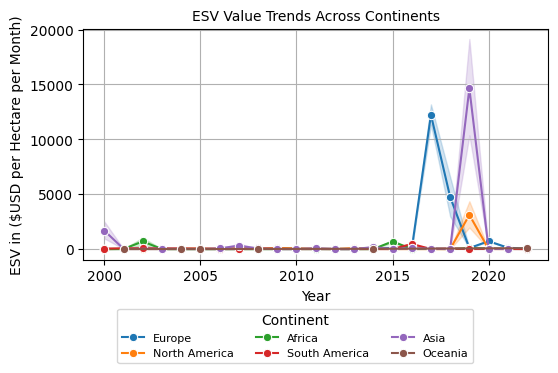

In [21]:
# Visualize ESV Trends Across Continents

# Filter out the "Global" category
continent_filtered = esv_monthly_df[esv_monthly_df["Continent"] != "Global"]


# Plot ESV trends by continent over time
plt.figure(figsize=(6, 3))
sns.lineplot(data=continent_filtered, x='year', y='Int$ Per Hectare Per Year', hue='Continent', marker='o')

# Modify labels and title
plt.title('ESV Value Trends Across Continents', fontsize=10)
plt.xlabel('Year')
plt.ylabel('ESV in ($USD per Hectare per Month)')

# Update legend to exclude "Global"
plt.legend(title='Continent', loc='upper right', bbox_to_anchor=(0.85, -0.19), ncol=3, fontsize=8)
plt.grid()

# Show the plot
plt.show()


# Step 4. Correlation Analysis between the Variables (KNDVI+Precip+ESV)


In [22]:
from scipy.stats import spearmanr, pearsonr

In [29]:
# Load datasets
chirps_df =  pd.read_csv("CHIRPS_Monthly_TimeSeries_Fixed.csv")
esv_df = pd.read_csv("Filtered_ESV.csv")
kndvi_df = pd.read_csv("NDVI_Time_Series_With_Country_Continent25.csv")

# Confirm column names for each dataset
print("NDVI Dataset Columns:")
print(kndvi_df.columns)

print("\nCHIRPS Dataset Columns:")
print(chirps_df.columns)

print("\nESV Dataset Columns:")
print(esv_df.columns)

NDVI Dataset Columns:
Index(['system:index', 'Continent', 'Country', 'Latitude', 'Longitude', 'date',
       'mean', '.geo', 'NDVI_Ref', 'KNDVI'],
      dtype='object')

CHIRPS Dataset Columns:
Index(['system:index', 'Continent', 'Countries', 'Latitude', 'Longitude',
       'date', 'mean', '.geo'],
      dtype='object')

ESV Dataset Columns:
Index(['Continent', 'year', 'month', 'ESVD2.0_Biome',
       'Int$ Per Hectare Per Year', 'date'],
      dtype='object')


In [30]:
chirps_df.head()

,system:index,Continent,Countries,Latitude,Longitude,date,mean,.geo
0,0_0,Europe,"Germany, Federal Republic of",50.616667,6.433333,2000-01,0.0,"{""type"":""Point"",""coordinates"":[6.433333,50.616..."
1,0_1,Europe,"Germany, Federal Republic of",49.000000,12.666667,2000-01,0.0,"{""type"":""Point"",""coordinates"":[12.666666999999..."
2,0_2,Europe,"Germany, Federal Republic of",51.096667,10.390833,2000-01,0.0,"{""type"":""Point"",""coordinates"":[10.390832999999..."
3,0_3,Europe,"Germany, Federal Republic of",53.439444,12.836667,2000-01,0.0,"{""type"":""Point"",""coordinates"":[12.836667000000..."
4,0_4,Europe,"Germany, Federal Republic of",51.166000,9.000000,2000-01,0.0,"{""type"":""Point"",""coordinates"":[9.0,51.166]}"


In [31]:
esv_df.head()

,Continent,year,month,ESVD2.0_Biome,Int$ Per Hectare Per Year,date
0,Europe,2010,1,Temperate forests and woodlands; Rivers and la...,49.40485,2010-01-01
1,Europe,2010,2,Temperate forests and woodlands; Rivers and la...,49.40485,2010-02-01
2,Europe,2010,3,Temperate forests and woodlands; Rivers and la...,49.40485,2010-03-01
3,Europe,2010,4,Temperate forests and woodlands; Rivers and la...,49.40485,2010-04-01
4,Europe,2010,5,Temperate forests and woodlands; Rivers and la...,49.40485,2010-05-01


In [32]:
kndvi_df.head()

,system:index,Continent,Country,Latitude,Longitude,date,mean,.geo,NDVI_Ref,KNDVI
0,2000_02_01_0,Europe,"Germany, Federal Republic of",50.616667,6.433333,2000-02-01,5773.0,"{""type"":""Point"",""coordinates"":[6.433333,50.616...",0.5773,0.78865
1,2000_02_01_1,Europe,"Germany, Federal Republic of",49.000000,12.666667,2000-02-01,5630.0,"{""type"":""Point"",""coordinates"":[12.666666999999...",0.5630,0.78150
2,2000_02_01_2,Europe,"Germany, Federal Republic of",51.096667,10.390833,2000-02-01,5052.0,"{""type"":""Point"",""coordinates"":[10.390832999999...",0.5052,0.75260
3,2000_02_01_3,Europe,"Germany, Federal Republic of",53.439444,12.836667,2000-02-01,5042.0,"{""type"":""Point"",""coordinates"":[12.836667000000...",0.5042,0.75210
4,2000_02_01_4,Europe,"Germany, Federal Republic of",51.166000,9.000000,2000-02-01,5470.0,"{""type"":""Point"",""coordinates"":[9.0,51.166]}",0.5470,0.77350


In [33]:
# # Correlation (ESV+Precip+KNDVI) For the entire dataset WITH 95%CI.

# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


# Convert date columns to datetime format
chirps_df['date'] = pd.to_datetime(chirps_df['date'], format='%Y-%m').dt.to_period('M').astype(str)
esv_df['date'] = pd.to_datetime(esv_df['date']).dt.to_period('M').astype(str)
kndvi_df['date'] = pd.to_datetime(kndvi_df['date']).dt.to_period('M').astype(str)



In [40]:
# Convert relevant columns to numeric

esv_df.rename(columns={'Int$ Per Hectare Per Year': 'ESV_Value'}, inplace=True)
esv_df['ESV_Value'] = pd.to_numeric(esv_df['ESV_Value'], errors='coerce')

kndvi_df.rename(columns={'mean': 'KNDVI_Value'}, inplace=True)
kndvi_df['KNDVI_Value'] = pd.to_numeric(kndvi_df['KNDVI_Value'], errors='coerce')

chirps_df.rename(columns={"mean": "mean_precip"}, inplace=True)
chirps_df['mean_precip'] = pd.to_numeric(chirps_df['mean_precip'], errors='coerce')


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Aggregate and merge datasets for all biomes
agg_df = pd.merge(
    chirps_df.groupby(['Continent', 'date'], as_index=False)['mean_precip'].mean(),
    esv_df[['Continent','date','ESVD2.0_Biome','ESV_Value']].groupby(['Continent','date', 'ESVD2.0_Biome'], as_index=False)['ESV_Value'].mean(),
    on=['Continent','date'], how='inner'
)

In [43]:
agg_df.head()

,Continent,date,mean_precip,ESVD2.0_Biome,ESV_Value
0,Africa,2000-01,0.000000,Inland wetlands; Tropical and subtropical forests,0.039558
1,Africa,2000-01,0.000000,Tropical and subtropical forests,0.023312
2,Africa,2000-01,0.000000,Tropical and subtropical forests; Coastal systems,0.063140
3,Africa,2000-01,0.000000,Tropical and subtropical forests; Inland wetla...,0.006400
4,Africa,2000-02,58.357796,Inland wetlands; Tropical and subtropical forests,0.039558


In [48]:
all_agg_df = pd.merge(
    agg_df[['Continent','date','ESVD2.0_Biome','ESV_Value','mean_precip']],
    kndvi_df[['Continent', 'date', 'KNDVI']],
    on=['Continent', 'date'], how='inner'
).groupby(['Continent','date','ESVD2.0_Biome'], as_index=False).mean()

# Drop missing values before computing correlation
all_agg_df.dropna(inplace=True)
all_agg_df.head()



,Continent,date,ESVD2.0_Biome,ESV_Value,mean_precip,KNDVI
0,Africa,2000-02,Inland wetlands; Tropical and subtropical forests,0.039558,58.357796,0.710012
1,Africa,2000-02,Tropical and subtropical forests,0.023312,58.357796,0.710012
2,Africa,2000-02,Tropical and subtropical forests; Coastal systems,0.063140,58.357796,0.710012
3,Africa,2000-02,Tropical and subtropical forests; Inland wetla...,0.006400,58.357796,0.710012
4,Africa,2000-03,Inland wetlands; Tropical and subtropical forests,0.039558,75.223632,0.723554


In [49]:
# scaling the ESV values
x = all_agg_df['ESV_Value'].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
all_agg_df['scaled_ESV']=x_scaled

x = all_agg_df['mean_precip'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))

all_agg_df['scaled_precip']=x_scaled

all_agg_df=all_agg_df.sort_values(['Continent','date'])

all_agg_df.to_csv('all_agg_df.csv') # scaling globally for ESV whereas the scaling for continent analysis was done per continent



In [51]:

#  Aggregate and merge datasets for FOREST biomes only
# filter the rows that contain the substring

substring = 'forest'
bfilter = esv_df['ESVD2.0_Biome'].str.contains(substring)
filtered_esv_df = esv_df[bfilter]

agg_df_filtered = pd.merge(
    chirps_df.groupby(['Continent','date'], as_index=False)['mean_precip'].mean(),
    filtered_esv_df[['Continent','date','ESVD2.0_Biome','ESV_Value']].groupby(['Continent','date', 'ESVD2.0_Biome'], as_index=False)['ESV_Value'].mean(),
    on=['Continent','date'], how='inner'
)

forest_agg_df = pd.merge(
    agg_df_filtered,
    kndvi_df.groupby(['Continent','date'], as_index=False)['KNDVI'].mean(),
    on=['Continent','date'], how='inner'
)
# Drop missing values before computing correlation
forest_agg_df.dropna(inplace=True)
forest_agg_df.head() 

,Continent,date,mean_precip,ESVD2.0_Biome,ESV_Value,KNDVI
0,Africa,2000-02,58.357796,Inland wetlands; Tropical and subtropical forests,0.039558,0.710012
1,Africa,2000-02,58.357796,Tropical and subtropical forests,0.023312,0.710012
2,Africa,2000-02,58.357796,Tropical and subtropical forests; Coastal systems,0.063140,0.710012
3,Africa,2000-02,58.357796,Tropical and subtropical forests; Inland wetla...,0.006400,0.710012
4,Africa,2000-03,75.223632,Inland wetlands; Tropical and subtropical forests,0.039558,0.723554


In [52]:


# scaling the ESV values
x = forest_agg_df['ESV_Value'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
forest_agg_df['scaled_ESV']=x_scaled

x = forest_agg_df['mean_precip'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))

forest_agg_df['scaled_precip']=x_scaled

forest_agg_df=forest_agg_df.sort_values(['Continent','ESVD2.0_Biome','date'])

forest_agg_df.to_csv('forest_agg_df.csv') # scaling globally for ESV whereas the scaling for continent analysis was done per continent


In [53]:

# Pearson Confidence Interval Function
def pearson_ci(x, y, confidence=0.95):
    r, p_value = stats.pearsonr(x, y)
    n = len(x)

    if n < 4:
        return r, p_value, None, None  # Not enough data for CI

    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)  # Critical z-score

    z_lower = z - z_critical * se
    z_upper = z + z_critical * se

    r_lower = np.tanh(z_lower)  # Convert back to correlation scale
    r_upper = np.tanh(z_upper)

    return r, p_value, r_lower, r_upper

# Spearman Confidence Interval Function (Bootstrapping)
def spearman_ci(x, y, num_samples=1000, confidence=0.95):
    boot_corrs = []
    n = len(x)

    if n < 4:
        return None, None  # Not enough data for CI

    for _ in range(num_samples):
        sample_idx = np.random.choice(range(n), size=n, replace=True)
        sample_corr, _ = stats.spearmanr(x.iloc[sample_idx], y.iloc[sample_idx])
        boot_corrs.append(sample_corr)

    lower_bound = np.percentile(boot_corrs, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_corrs, (1 + confidence) / 2 * 100)

    return lower_bound, upper_bound

# Compute Pearson and Spearman Correlations with Confidence Intervals
correlation_results_all = {}

for x_col, y_col in [('scaled_precip', 'scaled_ESV'), ('KNDVI', 'scaled_ESV'), ('scaled_precip', 'KNDVI')]:
    r, p, r_low, r_high = pearson_ci(all_agg_df[x_col], all_agg_df[y_col])
    s_low, s_high = spearman_ci(all_agg_df[x_col], all_agg_df[y_col])

    correlation_results_all["Pearson: "+ x_col+" vs "+y_col +"r, pvalue, CI"] = (r, p, r_low, r_high)
    correlation_results_all["Spearman: "+ x_col+" vs "+y_col+"r, pvalue, CI"] = (s_low, s_high)

correlation_results_all

{'Pearson: scaled_precip vs scaled_ESVr, pvalue, CI': (np.float64(-0.0429105747093404),
  np.float64(0.022899574682533105),
  np.float64(-0.07975423109071525),
  np.float64(-0.00594983417316046)),
 'Spearman: scaled_precip vs scaled_ESVr, pvalue, CI': (np.float64(-0.124879010156525),
  np.float64(-0.05044026800691033)),
 'Pearson: KNDVI vs scaled_ESVr, pvalue, CI': (np.float64(-0.0034024327868233673),
  np.float64(0.856906527715037),
  np.float64(-0.040367534435580096),
  np.float64(0.03357196960497882)),
 'Spearman: KNDVI vs scaled_ESVr, pvalue, CI': (np.float64(0.0009956421384579),
  np.float64(0.07501016186750491)),
 'Pearson: scaled_precip vs KNDVIr, pvalue, CI': (np.float64(0.6106877495884289),
  np.float64(5.1598239174766706e-287),
  np.float64(0.5869697239569199),
  np.float64(0.6333584461073617)),
 'Spearman: scaled_precip vs KNDVIr, pvalue, CI': (np.float64(0.5401247096754148),
  np.float64(0.5956183725103509))}

In [54]:
# Compute Pearson and Spearman Correlations with Confidence Intervals
correlation_results_forest = {}
for x_col, y_col in [('scaled_precip', 'scaled_ESV'), ('KNDVI', 'scaled_ESV'), ('scaled_precip', 'KNDVI')]:
    r, p, r_low, r_high = pearson_ci(forest_agg_df[x_col], forest_agg_df[y_col])
    s_low, s_high = spearman_ci(forest_agg_df[x_col], forest_agg_df[y_col])

    correlation_results_forest["Pearson: "+ x_col+" vs "+y_col +"r, pvalue, CI"] = (r, p, r_low, r_high)
    correlation_results_forest["Spearman: "+ x_col+" vs "+y_col+"r, pvalue, CI"] = (s_low, s_high)

correlation_results_forest

{'Pearson: scaled_precip vs scaled_ESVr, pvalue, CI': (np.float64(-0.01417608957128344),
  np.float64(0.5087521624019244),
  np.float64(-0.05617289724955844),
  np.float64(0.027870793436468397)),
 'Spearman: scaled_precip vs scaled_ESVr, pvalue, CI': (np.float64(-0.12381868039414955),
  np.float64(-0.04172907852476815)),
 'Pearson: KNDVI vs scaled_ESVr, pvalue, CI': (np.float64(0.03999811325521979),
  np.float64(0.0621727416064556),
  np.float64(-0.0020355857257153805),
  np.float64(0.08189072105504075)),
 'Spearman: KNDVI vs scaled_ESVr, pvalue, CI': (np.float64(0.04240527308918028),
  np.float64(0.1273660846441299)),
 'Pearson: scaled_precip vs KNDVIr, pvalue, CI': (np.float64(0.6229329987146675),
  np.float64(5.115948425755988e-234),
  np.float64(0.5965208586339145),
  np.float64(0.6479973781712598)),
 'Spearman: scaled_precip vs KNDVIr, pvalue, CI': (np.float64(0.5641395573757417),
  np.float64(0.6235370735705033))}

In [55]:
Africa_df=all_agg_df.where(all_agg_df['Continent']=='Africa').dropna()
Europe_df=all_agg_df.where(all_agg_df['Continent']=='Europe').dropna()
South_America_df=all_agg_df.where(all_agg_df['Continent']=='South America').dropna()
North_America_df=all_agg_df.where(all_agg_df['Continent']=='North America').dropna()
Asia_df=all_agg_df.where(all_agg_df['Continent']=='Asia').dropna()
Oceania_df=all_agg_df.where(all_agg_df['Continent']=='Oceania').dropna()
Oceania_df.head()


,Continent,date,ESVD2.0_Biome,ESV_Value,mean_precip,KNDVI,scaled_ESV,scaled_precip
2249,Oceania,2001-01,Tropical and subtropical forests,0.790179,279.850200,0.869699,0.000035,0.527721
2250,Oceania,2001-02,Tropical and subtropical forests,0.790179,469.464080,0.869149,0.000035,0.912042
2251,Oceania,2001-03,Tropical and subtropical forests,0.790179,191.215385,0.885948,0.000035,0.348071
2252,Oceania,2001-04,Tropical and subtropical forests,0.790179,223.772239,0.866820,0.000035,0.414059
2253,Oceania,2001-05,Tropical and subtropical forests,0.790179,124.480338,0.903117,0.000035,0.212808


In [56]:
#Europe_df.to_csv("europe.csv", index=False)
#Asia_df.to_csv("asia.csv", index=False)
#North_America_df.to_csv("north_america.csv", index=False)
#South_America_df.to_csv("south_america.csv", index=False)
#Africa_df.to_csv("africa.csv", index=False)
#Oceania_df.to_csv("oceania.csv", index=False)

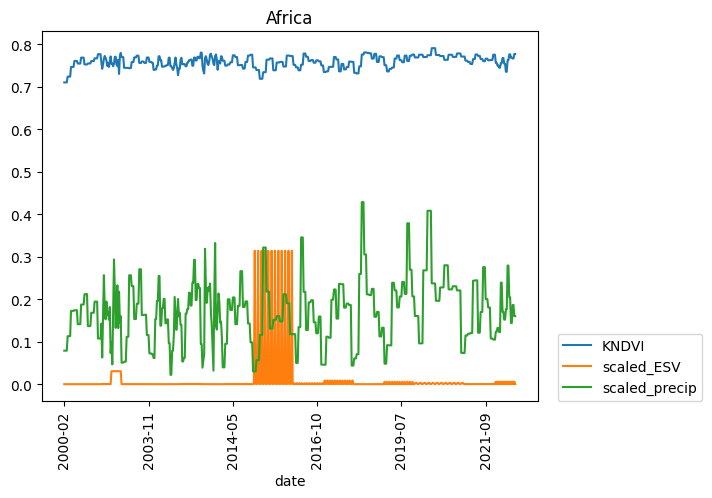

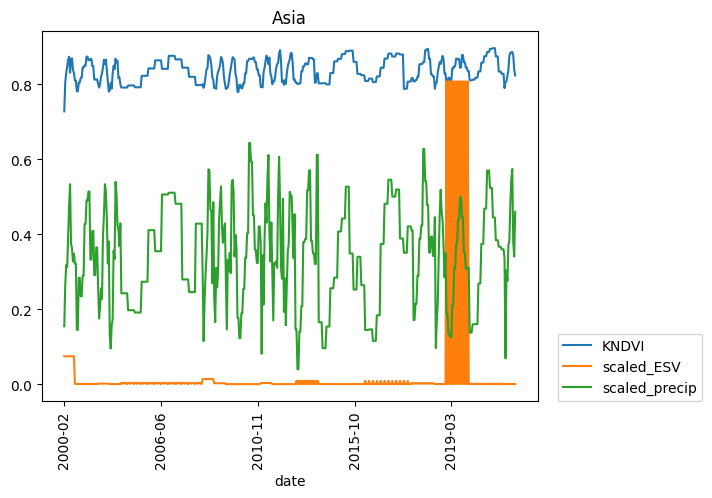

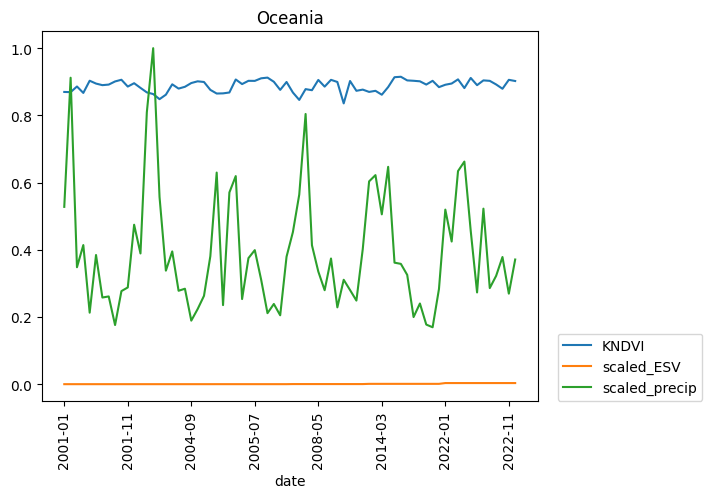

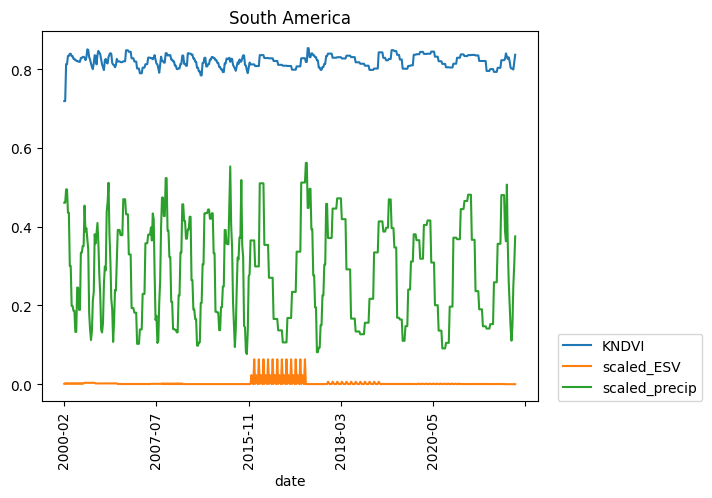

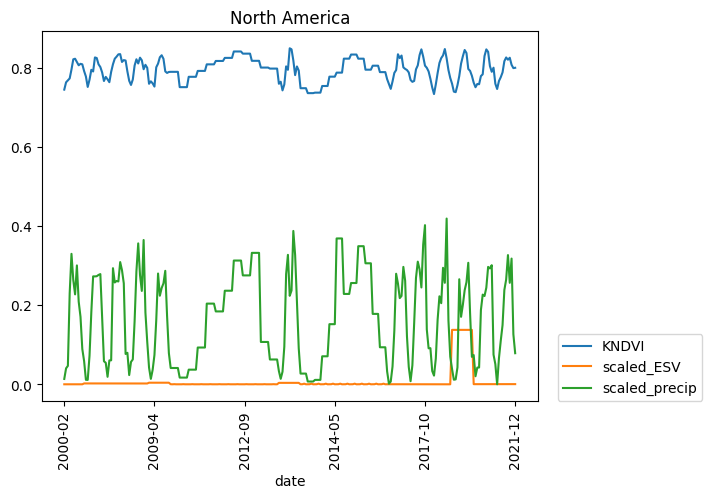

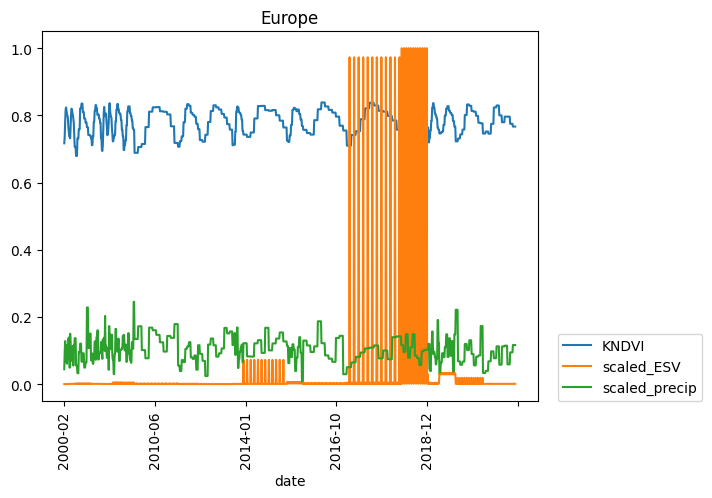

In [57]:

Africa_df[['date','KNDVI','scaled_ESV','scaled_precip']].plot(x='date',title='Africa')
plt.xticks(rotation=90)
plt.legend(loc=(1.04, 0), ncol=1)
Asia_df[['date','KNDVI','scaled_ESV','scaled_precip']].plot(x='date',title='Asia')
plt.xticks(rotation=90)
plt.legend(loc=(1.04, 0), ncol=1)
Oceania_df[['date','KNDVI','scaled_ESV','scaled_precip']].plot(x='date',title='Oceania')
plt.xticks(rotation=90)
plt.legend(loc=(1.04, 0), ncol=1)
South_America_df[['date','KNDVI','scaled_ESV','scaled_precip']].plot(x='date',title='South America')
plt.xticks(rotation=90)
plt.legend(loc=(1.04, 0), ncol=1)
North_America_df[['date','KNDVI','scaled_ESV','scaled_precip']].plot(x='date',title='North America')
plt.xticks(rotation=90)
plt.legend(loc=(1.04, 0), ncol=1)
Europe_df[['date','KNDVI','scaled_ESV','scaled_precip']].plot(x='date',title='Europe')
plt.xticks(rotation=90)
plt.legend(loc=(1.04, 0), ncol=1)
plt.show()


In [58]:
all_agg_df[['KNDVI', 'scaled_ESV', 'scaled_precip']].corr(method='pearson')

,KNDVI,scaled_ESV,scaled_precip
KNDVI,1.000000,-0.003402,0.610688
scaled_ESV,-0.003402,1.000000,-0.042911
scaled_precip,0.610688,-0.042911,1.000000


In [59]:
forest_agg_df[['KNDVI', 'scaled_ESV', 'scaled_precip']].corr(method='pearson')

,KNDVI,scaled_ESV,scaled_precip
KNDVI,1.000000,0.039998,0.622933
scaled_ESV,0.039998,1.000000,-0.014176
scaled_precip,0.622933,-0.014176,1.000000


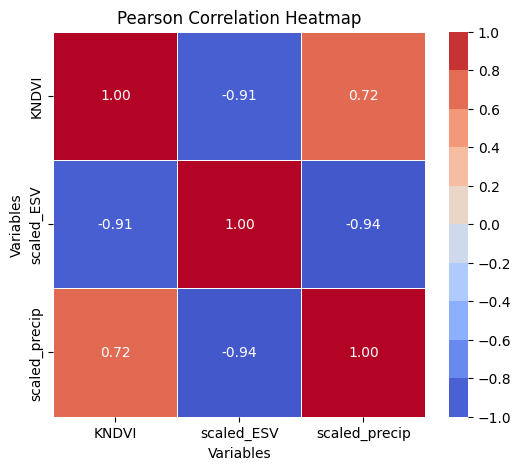

In [60]:
import seaborn as sns
plt.figure(figsize=(6, 5))
# Define discrete color bar ticks
discrete_levels = np.linspace(-1, 1, num=11)  # 11 levels for better readability

sns.heatmap(all_agg_df[['KNDVI', 'scaled_ESV', 'scaled_precip']].corr(method='pearson')[['KNDVI', 'scaled_ESV', 'scaled_precip']].corr(method='pearson'), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,
            center=0, cbar_kws={"ticks": discrete_levels, "boundaries": discrete_levels})
            # Add 'boundaries' for discrete colorbar
        
# Formatting
plt.title("Pearson Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

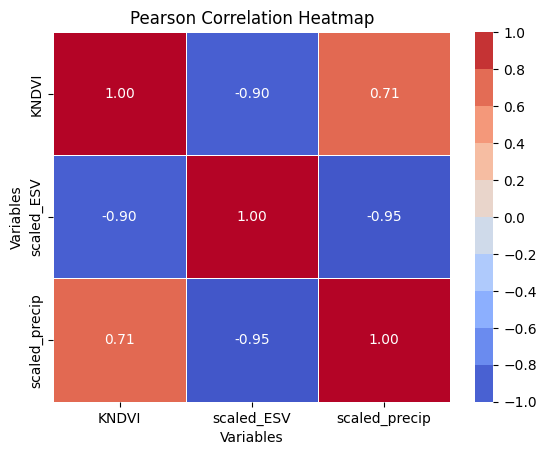

In [61]:
sns.heatmap(forest_agg_df[['KNDVI', 'scaled_ESV', 'scaled_precip']].corr(method='pearson')[['KNDVI', 'scaled_ESV', 'scaled_precip']].corr(method='pearson'), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,
            center=0, cbar_kws={"ticks": discrete_levels, "boundaries": discrete_levels})
            # Add 'boundaries' for discrete colorbar
        
# Formatting
plt.title("Pearson Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

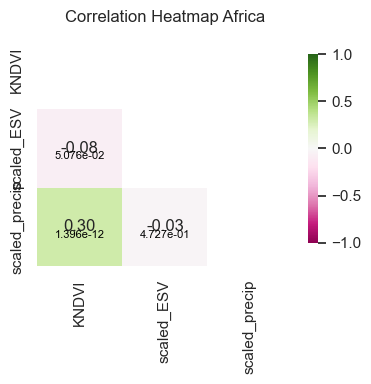

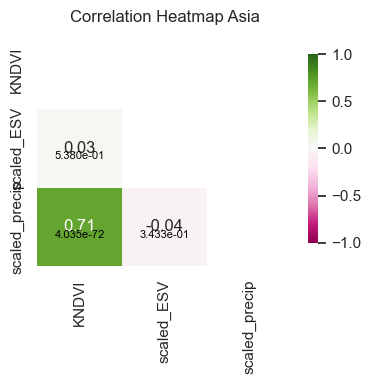

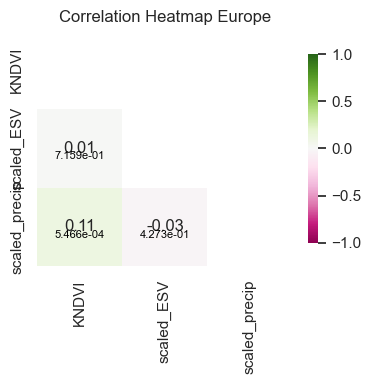

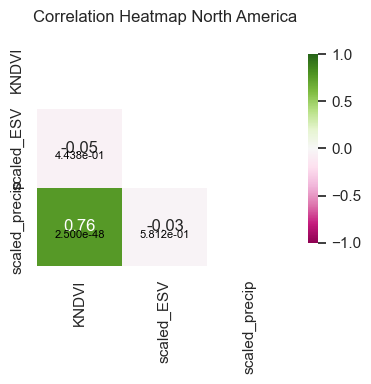

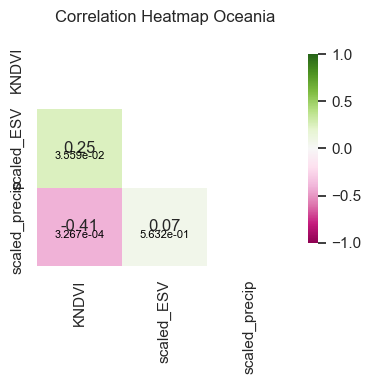

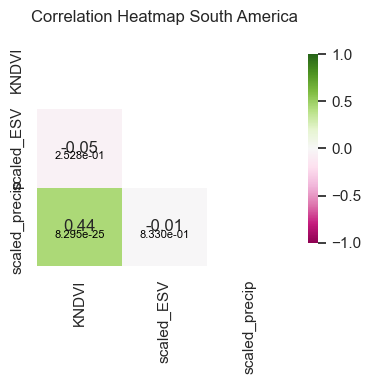

,0,1,2,3,4,5
0,Africa,-0.084425,0.299641,-0.031083,KNDVI scaled_ESV scaled_pr...,KNDVI scaled_ESV scale...
1,Asia,0.028568,0.707534,-0.043948,KNDVI scaled_ESV scaled_pr...,KNDVI scaled_ESV scale...
2,Europe,0.011552,0.109397,-0.025195,KNDVI scaled_ESV scaled_pr...,KNDVI scaled_ESV scaled_pr...
3,North America,-0.048555,0.759106,-0.034986,KNDVI scaled_ESV scaled_pr...,KNDVI scaled_ESV scale...
4,Oceania,0.248124,-0.411718,0.06926,KNDVI scaled_ESV scaled_pr...,KNDVI scaled_ESV scaled_pr...
5,South America,-0.051759,0.441624,-0.009548,KNDVI scaled_ESV scaled_pr...,KNDVI scaled_ESV scale...


In [63]:
# Plot the correlation matrix with pvalues per continent for scaled ESV-KNDVI-Precipitation values

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

from decimal import Decimal
# Initialize a dictionary to store results for each continent
continents = all_agg_df['Continent'].unique()
mhm=list()
corr_mat_mat = pd.DataFrame()
# Loop through each continent to perform separate analysis
for i in range(0,6):
    #selected=final_df_scaled[['KNDVI', 'scaled_ESV', 'scaled_precip']].where(final_df_scaled['Continent']==continents[i])
    mask= all_agg_df['Continent'] == continents[i]
    selected = all_agg_df[mask][['KNDVI', 'scaled_ESV', 'scaled_precip']]
    # Calculate the correlation matrix and p-values
    corr_matrix = selected.apply(lambda x: selected.apply(lambda y: pearson_ci(x, y)[0]))
    if not corr_matrix.empty:
        pvalues = selected.apply(lambda x: selected.apply(lambda y: pearson_ci(x, y)[1]))
        newframe= pd.DataFrame([continents[i], corr_matrix["KNDVI"][1], corr_matrix["KNDVI"][2],corr_matrix["scaled_ESV"][2], corr_matrix, pvalues])
                
        corr_mat_mat=pd.concat([corr_mat_mat, newframe.T], ignore_index=True)   
            
        
        # Generate the heatmap of the correlation matrix
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.set(style='white')
        fig, ax = plt.subplots(figsize=(4,4))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='PiYG', mask=mask, cbar_kws={'shrink': 0.8},
                    ax=ax, vmin=-1, vmax=1, center=0)

        mhm.append([continents[i], corr_matrix["KNDVI"][1], corr_matrix["KNDVI"][2], corr_matrix["scaled_ESV"][2]])
        
        # Update the heatmap labels with correlation coefficients and p-values
        plt.title('Correlation Heatmap ' + continents[i])
        for i in range(corr_matrix.shape[0]):
            for j in range(corr_matrix.shape[1]):
                if i >= j:
                    continue
                corr = '{:0.3}'.format(corr_matrix.iloc[i, j]),
                pval = '{:0.3e}'.format(pvalues.iloc[i, j])
                ax.text(j+0.5, i+0.5, corr, ha='center', va='center', fontsize=10, color='white')
                ax.text(i+0.5, j+0.6, pval, ha='center', va='center', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()
    plt.close()
corr_mat_mat

In [85]:
filtered_biome_df[["Continent", "ESVD2.0_Biome"]].apply(set, axis=1).sort_values().value_counts().index

Index([         {'Europe', 'Temperate forests and woodlands'},
                 {'Asia', 'Tropical and subtropical forests'},
        {'South America', 'Tropical and subtropical forests'},
               {'Africa', 'Tropical and subtropical forests'},
         {'South America', 'Temperate forests and woodlands'},
        {'North America', 'Tropical and subtropical forests'},
                  {'Asia', 'Temperate forests and woodlands'},
       {'Boreal and montane forests and woodlands', 'Europe'},
                {'Africa', 'Temperate forests and woodlands'},
              {'Oceania', 'Tropical and subtropical forests'},
         {'Asia', 'Boreal and montane forests and woodlands'},
         {'North America', 'Temperate forests and woodlands'},
       {'Boreal and montane forests and woodlands', 'Africa'}],
      dtype='object')

In [94]:
continents

array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], dtype=object)

1 1


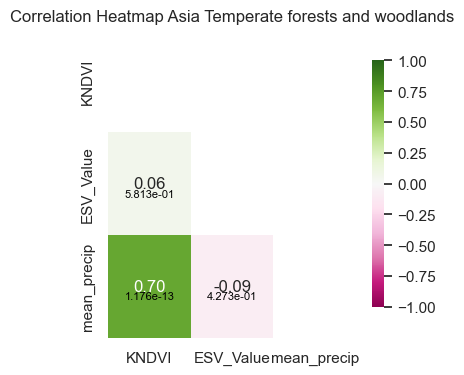

2 2


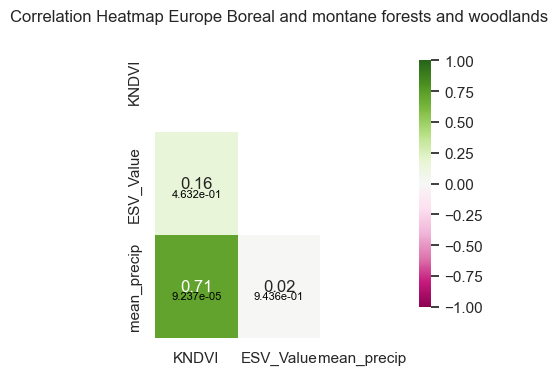

2 1


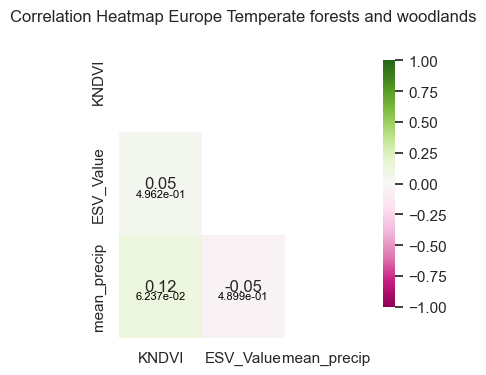

3 1


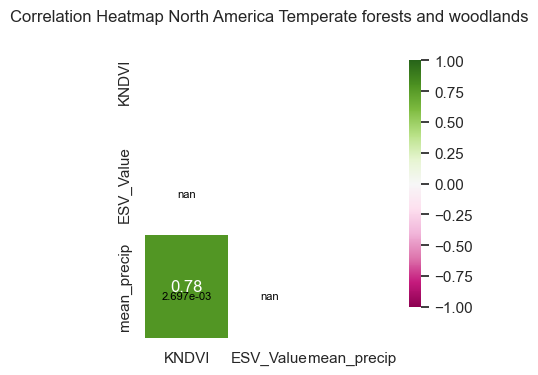

5 1


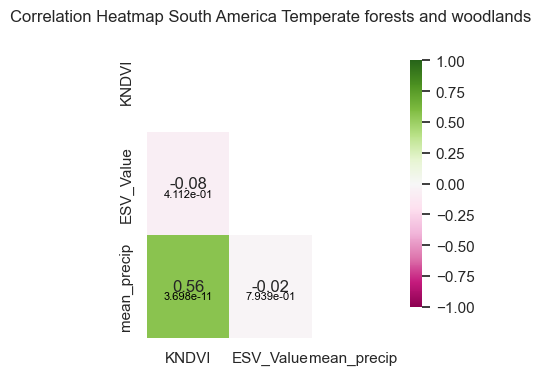

In [95]:
## Plot the correlation matrix with pvalues per continent and signle forest biome (not composite) for scaled ESV-KNDVI-Precipitation values

substring = ';' # for unique biome / no mixture
filter = forest_agg_df['ESVD2.0_Biome'].str.contains(substring)
filtered_biome_df = forest_agg_df[~filter]

corr_mat_mat = pd.DataFrame()
biomes_nb=[3,3,2,2,1,2]
continents= ['Africa', 'Asia', 'Europe', 'North America', 'Oceania','South America']
biomes = ['Tropical and subtropical forests', 'Temperate forests and woodlands', 'Boreal and montane forests and woodlands',
'Tropical and subtropical forests', 'Temperate forests and woodlands', 'Boreal and montane forests and woodlands',
'Temperate forests and woodlands', 'Boreal and montane forests and woodlands', 'Tropical and subtropical forests',
'Temperate forests and woodlands' , 'Tropical and subtropical forests', 'Tropical and subtropical forests',
'Temperate forests and woodlands']



# Loop through each continent and biome to perform separate analysis
for i in range(1,len(continents)):
    mask= filtered_biome_df['Continent'] == continents[i]
    selected_b = filtered_biome_df[mask][['Continent','ESVD2.0_Biome','KNDVI', 'ESV_Value', 'mean_precip']]
    for j in range(1,biomes_nb[i]):
            print(i,j)
            maskb= filtered_biome_df['ESVD2.0_Biome'] == biomes[j]
            selected=selected_b[maskb][['KNDVI', 'ESV_Value', 'mean_precip']]
        
        # Calculate the correlation matrix and p-values
            corr_matrix = selected.apply(lambda x: selected.apply(lambda y: pearson_ci(x, y)[0]))
            if not corr_matrix.empty:
                pvalues = selected.apply(lambda x: selected.apply(lambda y: pearson_ci(x, y)[1]))
                newframe= pd.DataFrame([continents[i] , biomes[j], corr_matrix, pvalues])
                
                corr_mat_mat=pd.concat([corr_mat_mat, newframe.T], ignore_index=True)   
                
                
          # Generate the heatmap of the correlation matrix
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                sns.set(style='white')
                fig, ax = plt.subplots(figsize=(4,4))
                sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='PiYG', mask=mask, cbar_kws={'shrink': 0.8},
                            ax=ax, vmin=-1, vmax=1, center=0)          

            # Update the heatmap labels with correlation coefficients and p-values
                plt.title('Correlation Heatmap ' + continents[i]+' ' + biomes[j])
                for i in range(corr_matrix.shape[0]):
                    for j in range(corr_matrix.shape[1]):
                        if i >= j:
                            continue
                        corr = '{:0.3}'.format(corr_matrix.iloc[i, j]),
                        pval = '{:0.3e}'.format(pvalues.iloc[i, j])
                        ax.text(j+0.5, i+0.5, corr, ha='center', va='center', fontsize=10, color='white')
                        ax.text(i+0.5, j+0.6, pval, ha='center', va='center', fontsize=8, color='black')

            plt.show()
            plt.close()
        


In [96]:
corr_mat_mat.columns=['continent','biome', 'corr_matrix','pvalues_matrix']
corr_mat_mat.head()

,continent,biome,corr_matrix,pvalues_matrix
0,Asia,Temperate forests and woodlands,KNDVI ESV_Value mean_precip ...,KNDVI ESV_Value mean_pr...
1,Europe,Boreal and montane forests and woodlands,KNDVI ESV_Value mean_precip ...,KNDVI ESV_Value mean_precip ...
2,Europe,Temperate forests and woodlands,KNDVI ESV_Value mean_precip ...,KNDVI ESV_Value mean_precip ...
3,North America,Temperate forests and woodlands,KNDVI ESV_Value mean_precip ...,KNDVI ESV_Value mean_pr...
4,South America,Temperate forests and woodlands,KNDVI ESV_Value mean_precip ...,KNDVI ESV_Value mean_pr...


In [97]:
corr_mat_mat['corr_matrix'][0]

,KNDVI,ESV_Value,mean_precip
KNDVI,1.000000,0.061027,0.700676
ESV_Value,0.061027,1.000000,-0.087759
mean_precip,0.700676,-0.087759,1.000000


In [98]:
corr_mat_mat['corr_matrix'][0]['KNDVI'][1]

np.float64(0.06102719834242766)

In [99]:
corr_mat_mat['corr_matrix'][0]['ESV_Value'][2]

np.float64(-0.08775861570071597)

In [100]:
corr_mat_mat['continent'][0]

'Asia'

In [101]:
#corr_mat_mat.reset_index(drop=True, inplace=True)
biome = list()
cont= list()
kndvi_esv_corr = list()
kndvi_precip_corr = list()
esv_precip_corr = list()

for i in range(len(corr_mat_mat)):
    print('continent: ', corr_mat_mat['continent'][i],'biome: ', corr_mat_mat['biome'][i], 
          '\n Correlation KNDVI-ESV', corr_mat_mat['corr_matrix'][i]['KNDVI'][1],
        '\n Correlation KNDVI- Precip', corr_mat_mat['corr_matrix'][i]['KNDVI'][2],
          '\n Correlation ESV- Precip', corr_mat_mat['corr_matrix'][i]['ESV_Value'][2]
         )
    cont.append(corr_mat_mat['continent'][i]) # continent
    biome.append(corr_mat_mat['biome'][i]) #biome
    kndvi_esv_corr.append(corr_mat_mat['corr_matrix'][i]['KNDVI'][1]) # kndvi - esv
    kndvi_precip_corr.append(corr_mat_mat['corr_matrix'][i]['KNDVI'][2]) # kndvi - precip
    esv_precip_corr.append(corr_mat_mat['corr_matrix'][i]['ESV_Value'][2]) # kndvi - precip
    
    corr_df=pd.DataFrame([cont, biome, kndvi_esv_corr, kndvi_precip_corr,esv_precip_corr ])
    


final_corr=corr_df.T
final_corr.columns=['continent','biome','KNDVI-ESV','KNDVI-Precip','ESV-Precip']
final_corr= final_corr.dropna(subset=['KNDVI-ESV','KNDVI-Precip', 'ESV-Precip']).sort_values(['continent','biome'])
final_corr

continent:  Asia biome:  Temperate forests and woodlands 
 Correlation KNDVI-ESV 0.06102719834242766 
 Correlation KNDVI- Precip 0.7006760170743623 
 Correlation ESV- Precip -0.08775861570071597
continent:  Europe biome:  Boreal and montane forests and woodlands 
 Correlation KNDVI-ESV 0.15720153344655863 
 Correlation KNDVI- Precip 0.712936658826471 
 Correlation ESV- Precip 0.015257594773589567
continent:  Europe biome:  Temperate forests and woodlands 
 Correlation KNDVI-ESV 0.045389304004577 
 Correlation KNDVI- Precip 0.12390316550527353 
 Correlation ESV- Precip -0.046062622207604494
continent:  North America biome:  Temperate forests and woodlands 
 Correlation KNDVI-ESV nan 
 Correlation KNDVI- Precip 0.7812341238561727 
 Correlation ESV- Precip nan
continent:  South America biome:  Temperate forests and woodlands 
 Correlation KNDVI-ESV -0.07570663348499113 
 Correlation KNDVI- Precip 0.5576259385381659 
 Correlation ESV- Precip -0.024093442497174558


,continent,biome,KNDVI-ESV,KNDVI-Precip,ESV-Precip
0,Asia,Temperate forests and woodlands,0.061027,0.700676,-0.087759
1,Europe,Boreal and montane forests and woodlands,0.157202,0.712937,0.015258
2,Europe,Temperate forests and woodlands,0.045389,0.123903,-0.046063
4,South America,Temperate forests and woodlands,-0.075707,0.557626,-0.024093


In [103]:
filtered_biome_df.head()

,Continent,date,mean_precip,ESVD2.0_Biome,ESV_Value,KNDVI,scaled_ESV,scaled_precip
104,Africa,2011-01,45.860884,Boreal and montane forests and woodlands,14.458935,0.752634,0.000656,0.053458
106,Africa,2011-02,49.983482,Boreal and montane forests and woodlands,14.458935,0.753064,0.000656,0.061814
108,Africa,2011-03,101.309805,Boreal and montane forests and woodlands,14.458935,0.747945,0.000656,0.165845
110,Africa,2011-04,106.579190,Boreal and montane forests and woodlands,14.458935,0.756832,0.000656,0.176525
112,Africa,2011-05,125.628457,Boreal and montane forests and woodlands,14.458935,0.762068,0.000656,0.215135


In [272]:
f= filtered_biome_df.groupby(['Continent','ESVD2.0_Biome'])[['mean_precip','ESV_Value','KNDVI']].corr().reset_index()
f.dropna(subset=['mean_precip','ESV_Value','KNDVI'], inplace=True)
r=f[f['level_2']=='mean_precip'].drop(['level_2','mean_precip'], axis=1)
r.columns=['continent','biome','ESV_precip','KNDVI_precip']
b= f[f['level_2']=='ESV_Value'].drop(['level_2','mean_precip', 'ESV_Value'], axis=1)
b.columns=['continent','biome','ESV_KNDVI']
corr_biome = pd.merge(r,b, on=['continent','biome'], how='inner')
corr_biome


,continent,biome,ESV_precip,KNDVI_precip,ESV_KNDVI
0,Africa,Temperate forests and woodlands,-0.087982,0.165509,-0.075820
1,Africa,Tropical and subtropical forests,0.201283,0.337500,0.305385
2,Asia,Boreal and montane forests and woodlands,0.015258,0.712937,0.157202
3,Asia,Temperate forests and woodlands,-0.087759,0.700676,0.061027
4,Asia,Tropical and subtropical forests,0.008767,0.703646,-0.015588
5,Europe,Boreal and montane forests and woodlands,0.011690,0.270523,0.018416
6,Europe,Temperate forests and woodlands,-0.046063,0.123903,0.045389
7,North America,Tropical and subtropical forests,0.015054,0.743277,0.017506
8,Oceania,Tropical and subtropical forests,0.110654,-0.654710,-0.291064
9,South America,Temperate forests and woodlands,-0.024093,0.557626,-0.075707


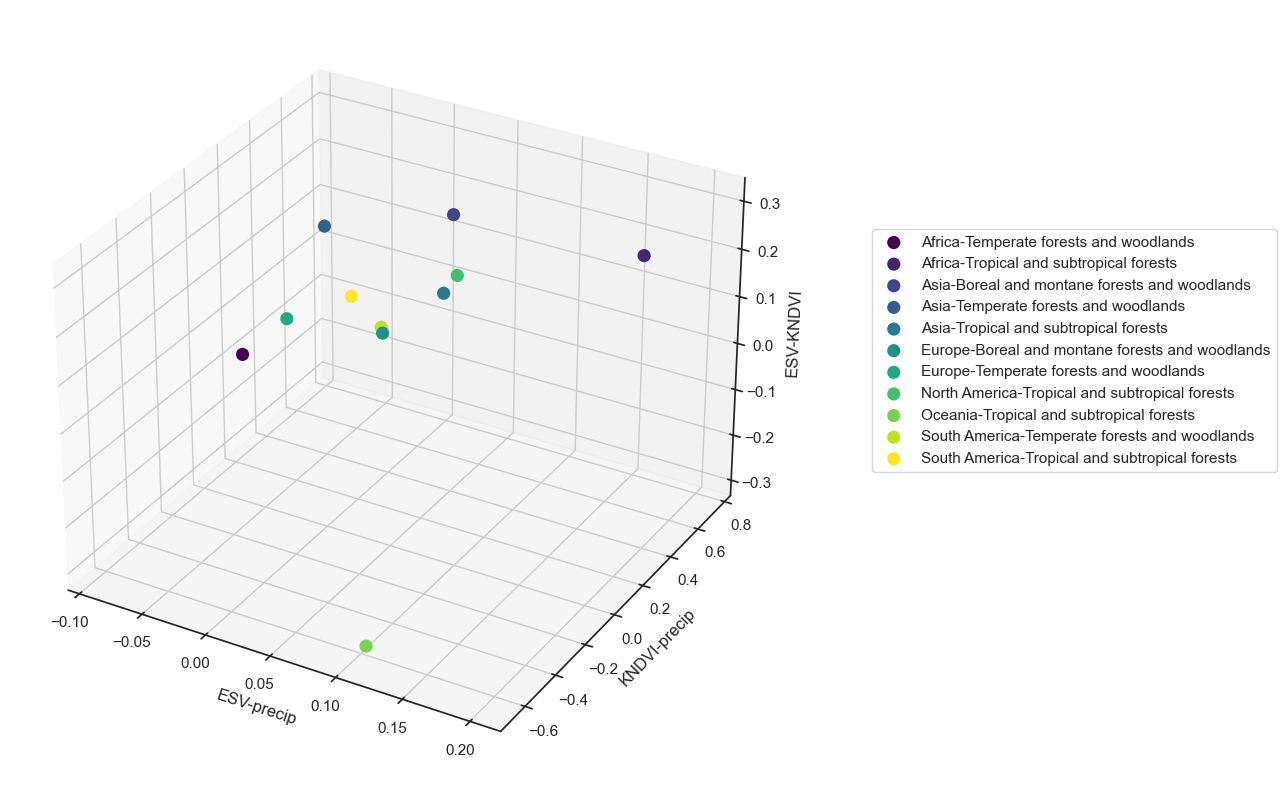

In [282]:

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(projection='3d')

c = [i for i in range(len(corr_biome))]
colors= np.array(c).flatten()

size=90 
cmap = plt.cm.viridis
norm = plt.Normalize(colors.min(), colors.max())
df = pd.DataFrame({"x":corr_biome['ESV_precip'], 
                   "y":corr_biome['KNDVI_precip'], 
                   "z":corr_biome['ESV_KNDVI'], 
                   "cont":corr_biome['continent'], 
                   "colors":np.array(c).flatten()})

norm = plt.Normalize(df['colors'].values.min(), df['colors'].values.max())

for i, dff in df.groupby("colors"):
    
    ax.scatter(dff['x'], dff['y'],dff['z'], s=size, c=cmap(norm(dff['colors'])),
                edgecolors='none', label= corr_biome['continent'][i] + '-' + corr_biome['biome'][i] )


ax.set_xlabel('ESV-precip')
ax.set_ylabel('KNDVI-precip')
ax.set_zlabel('ESV-KNDVI')

plt.grid(True)

plt.legend(loc=(1.12, .4))
plt.show()

# Step 5. Dynamic ESV Estimation Using KNDVI Trends

In [108]:

# Select only relevant columns for analysis
esv_file = pd.read_csv("Filtered_ESV.csv")
esv_selected = esv_file[['Continent', 'year', 'ESVD2.0_Biome', 'Int$ Per Hectare Per Year']]

# Display the first few rows of the cleaned ESV dataset
print("Prepared ESV Data:")
print(esv_selected.head())

Prepared ESV Data:
  Continent  year                                      ESVD2.0_Biome  \
0    Europe  2010  Temperate forests and woodlands; Rivers and la...   
1    Europe  2010  Temperate forests and woodlands; Rivers and la...   
2    Europe  2010  Temperate forests and woodlands; Rivers and la...   
3    Europe  2010  Temperate forests and woodlands; Rivers and la...   
4    Europe  2010  Temperate forests and woodlands; Rivers and la...   

   Int$ Per Hectare Per Year  
0                   49.40485  
1                   49.40485  
2                   49.40485  
3                   49.40485  
4                   49.40485  


In [109]:
# Confirm column names for each dataset
print("NDVI Dataset Columns:")
print(kndvi_df.columns)

print("\nCHIRPS Dataset Columns:")
print(chirps_df.columns)

print("\nESV Dataset Columns:")
print(esv_df.columns)


NDVI Dataset Columns:
Index(['system:index', 'Continent', 'Country', 'Latitude', 'Longitude', 'date',
       'KNDVI_Value', '.geo', 'NDVI_Ref', 'KNDVI'],
      dtype='object')

CHIRPS Dataset Columns:
Index(['system:index', 'Continent', 'Countries', 'Latitude', 'Longitude',
       'date', 'mean_precip', '.geo'],
      dtype='object')

ESV Dataset Columns:
Index(['Continent', 'year', 'month', 'ESVD2.0_Biome', 'ESV_Value', 'date'], dtype='object')


In [110]:
# Conver the date columns to datetime and extract the years

# Convert date columns to datetime format
kndvi_df['date'] = pd.to_datetime(kndvi_df['date'], errors='coerce')
chirps_df['date'] = pd.to_datetime(chirps_df['date'], errors='coerce')
esv_df['date'] = pd.to_datetime(esv_df['date'], errors='coerce')
# Extract month for seasonal grouping
chirps_df['month'] = chirps_df['date'].dt.month
esv_df['month'] = esv_df['date'].dt.month
kndvi_df['month'] = kndvi_df['date'].dt.month

# Extract the year from the date column and create a new 'year' column
kndvi_df['year'] = kndvi_df['date'].dt.year  # Adding this line to extract year
chirps_df['year'] = chirps_df['date'].dt.year  # Adding this line to extract year
# Confirm the new column has been added correctly
print("NDVI Dataset After Adding Year Column:")
print(kndvi_df[['date', 'year']].head())

print("\nCHIRPS Dataset After Adding Year Column:")
print(chirps_df[['date', 'year']].head())

NDVI Dataset After Adding Year Column:
        date  year
0 2000-02-01  2000
1 2000-02-01  2000
2 2000-02-01  2000
3 2000-02-01  2000
4 2000-02-01  2000

CHIRPS Dataset After Adding Year Column:
        date  year
0 2000-01-01  2000
1 2000-01-01  2000
2 2000-01-01  2000
3 2000-01-01  2000
4 2000-01-01  2000


In [111]:
# Aggregate NDVI data by Continent and year, taking the mean of KNDVI
ndvi_agg = kndvi_df.groupby(['Continent', 'year'])['KNDVI'].mean().reset_index()

# Aggregate CHIRPS data by Continent and year, taking the mean of precipitation values
chirps_agg = chirps_df.groupby(['Continent', 'year'])['mean_precip'].mean().reset_index()

# Rename columns for clarity
chirps_agg.rename(columns={'mean': 'Precipitation_mean'}, inplace=True)


# Display results
print("Aggregated NDVI Data:")
print(ndvi_agg.head())

print("\nAggregated CHIRPS Data:")
print(chirps_agg.head())

Aggregated NDVI Data:
  Continent  year     KNDVI
0    Africa  2000  0.752069
1    Africa  2001  0.758075
2    Africa  2002  0.758006
3    Africa  2003  0.758224
4    Africa  2004  0.764589

Aggregated CHIRPS Data:
  Continent  year  mean_precip
0    Africa  2000    86.841330
1    Africa  2001    97.497208
2    Africa  2002   103.734505
3    Africa  2003    94.661875
4    Africa  2004    95.382422


In [112]:

# Merge NDVI and CHIRPS data on Continent and year
ndvi_chirps_merged = pd.merge(ndvi_agg, chirps_agg, on=['Continent', 'year'], how='inner')

# Merge the combined NDVI-CHIRPS dataset with ESV dataset
final_merged_df = pd.merge(ndvi_chirps_merged, esv_selected, on=['Continent', 'year'], how='inner')

# Display the first few rows of the merged dataset
print("Final Merged Dataset:")
print(final_merged_df.head())

# Check the shape to confirm number of records
print("\nFinal Merged Dataset Shape:", final_merged_df.shape)

Final Merged Dataset:
  Continent  year     KNDVI  mean_precip  \
0    Africa  2000  0.752069     86.84133   
1    Africa  2000  0.752069     86.84133   
2    Africa  2000  0.752069     86.84133   
3    Africa  2000  0.752069     86.84133   
4    Africa  2000  0.752069     86.84133   

                                       ESVD2.0_Biome  \
0  Tropical and subtropical forests; Coastal systems   
1  Tropical and subtropical forests; Coastal systems   
2  Tropical and subtropical forests; Coastal systems   
3  Tropical and subtropical forests; Coastal systems   
4  Tropical and subtropical forests; Coastal systems   

   Int$ Per Hectare Per Year  
0                   0.006142  
1                   0.006142  
2                   0.006142  
3                   0.006142  
4                   0.006142  

Final Merged Dataset Shape: (32412, 6)


In [113]:
final_merged_df.isnull().sum()

Continent                    0
year                         0
KNDVI                        0
mean_precip                  0
ESVD2.0_Biome                0
Int$ Per Hectare Per Year    0
dtype: int64

In [114]:
# Step 2:Impute missing values with the mean of the column
final_merged_df = final_merged_df.assign(esv_value=final_merged_df['Int$ Per Hectare Per Year'].fillna(final_merged_df['Int$ Per Hectare Per Year'].mean()))
final_merged_df.drop(['esv_value'], axis=1, inplace = True)
final_merged_df.head()

,Continent,year,KNDVI,mean_precip,ESVD2.0_Biome,Int$ Per Hectare Per Year
0,Africa,2000,0.752069,86.84133,Tropical and subtropical forests; Coastal systems,0.006142
1,Africa,2000,0.752069,86.84133,Tropical and subtropical forests; Coastal systems,0.006142
2,Africa,2000,0.752069,86.84133,Tropical and subtropical forests; Coastal systems,0.006142
3,Africa,2000,0.752069,86.84133,Tropical and subtropical forests; Coastal systems,0.006142
4,Africa,2000,0.752069,86.84133,Tropical and subtropical forests; Coastal systems,0.006142


In [135]:
# Calculate year-over-year change in KNDVI and precipitation
final_merged_df['KNDVI_trend'] = final_merged_df.groupby('Continent')['KNDVI'].diff()
final_merged_df['precipitation_trend'] = final_merged_df.groupby('Continent')['mean_precip'].diff()

# Fill missing values resulting from diff operation
final_merged_df.fillna(0, inplace=True)

# Display the updated dataset with new features
final_merged_df[['Continent', 'year', 'KNDVI', 'KNDVI_trend', 'mean_precip', 'precipitation_trend', 'Int$ Per Hectare Per Year']].head()


,Continent,year,KNDVI,KNDVI_trend,mean_precip,precipitation_trend,Int$ Per Hectare Per Year
0,Africa,2000,0.752069,0.0,86.84133,0.0,0.006142
1,Africa,2000,0.752069,0.0,86.84133,0.0,0.006142
2,Africa,2000,0.752069,0.0,86.84133,0.0,0.006142
3,Africa,2000,0.752069,0.0,86.84133,0.0,0.006142
4,Africa,2000,0.752069,0.0,86.84133,0.0,0.006142


In [137]:

# scaling the ESV values
x = final_merged_df['Int$ Per Hectare Per Year'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
final_merged_df['scaled_Int$ Per Hectare Per Year']=x_scaled

x = final_merged_df['mean_precip'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
final_merged_df['scaled_mean_precip']=x_scaled

In [136]:
# Model training

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select features and target variable
features = ['KNDVI', 'KNDVI_trend', 'mean_precip', 'precipitation_trend']
X = final_merged_df[features]
y = final_merged_df['Int$ Per Hectare Per Year']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print("Mean Absolute Error (MAE):" ,mae)
print("Root Mean Squared Error (RMSE): ",rmse)
print("R² Score:", r2)

Model Performance Metrics:
Mean Absolute Error (MAE): 841.3784616811574
Root Mean Squared Error (RMSE):  4111.844959829944
R² Score: 0.19162818805686122


In [147]:
# Model training

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select features and target variable
features = ['KNDVI', 'KNDVI_trend', 'scaled_mean_precip', 'precipitation_trend']
X = final_merged_df[features]
y = final_merged_df['scaled_Int$ Per Hectare Per Year']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics - Gradient Boosting:")
print("Mean Absolute Error (MAE):" ,mae)
print("Root Mean Squared Error (RMSE): ",rmse)
print("R² Score:", r2)

Model Performance Metrics - Gradient Boosting:
Mean Absolute Error (MAE): 0.005076944445266368
Root Mean Squared Error (RMSE):  0.02481115228726393
R² Score: 0.19162818143603366


In [141]:
# Code for Hyperparameter Tuning using GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate to shrink contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'subsample': [0.8, 1.0],  # Fraction of samples used to grow each tree
    'min_samples_split': [2, 5, 10]  # Minimum samples to split an internal node
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new model with the best found parameters
optimized_model = GradientBoostingRegressor(**best_params, random_state=42)
optimized_model.fit(X_train, y_train)

# Make predictions
y_pred_opt = optimized_model.predict(X_test)

# Evaluate performance
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print("\nOptimized Model Performance Metrics:")
print("Mean Absolute Error (MAE): ", mae_opt )
print("Root Mean Squared Error (RMSE):",rmse_opt )
print("R² Score: ",r2_opt)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}

Optimized Model Performance Metrics:
Mean Absolute Error (MAE):  0.005075322580930521
Root Mean Squared Error (RMSE): 0.024809950216814387
R² Score:  0.19170650882081286


In [140]:
# Step 1:  XGBoost Regression

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare DMatrix for XGBoost (optimized internal data structure)
# Convert X_train and X_test to NumPy arrays before creating DMatrix
dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train)  # Convert to NumPy array
dtest = xgb.DMatrix(X_test.to_numpy(), label=y_test)    # Convert to NumPy array

# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=200)

# Make predictions
y_pred_xgb = xgb_model.predict(dtest)

# Evaluate model performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print("Mean Absolute Error (MAE):", mae_xgb)
print("Root Mean Squared Error (RMSE):", rmse_xgb)
print("R² Score:", r2_xgb )

XGBoost Model Performance:
Mean Absolute Error (MAE): 0.005027632103795222
Root Mean Squared Error (RMSE): 0.024778356614042072
R² Score: 0.19376379983504222


In [139]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model with initial hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print("Mean Absolute Error (MAE): ", mae_rf )
print("Root Mean Squared Error (RMSE): ", rmse_rf )
print("R² Score:", r2_rf )


Random Forest Model Performance:
Mean Absolute Error (MAE):  0.0050380700946969295
Root Mean Squared Error (RMSE):  0.02480622019585721
R² Score: 0.1919495343001658


In [148]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Standard regression objective
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size
    max_depth=6,  # Depth of each tree
    random_state=42
)

# Train the model on the training dataset
# Convert X_train and y_train to NumPy arrays
xgb_model.fit(X_train.to_numpy(), y_train.to_numpy())

# Make predictions on the test set
# Convert X_test to a NumPy array
y_pred = xgb_model.predict(X_test.to_numpy())


# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

r2 = r2_score(y_test, y_pred)

# Print the results
print("XGBoost Model Performance:")
print("Mean Absolute Error (MAE): ", mae)
print("Root Mean Squared Error (RMSE): ", rmse )
print("R² Score:", r2 )

XGBoost Model Performance:
Mean Absolute Error (MAE):  0.005026807642945913
Root Mean Squared Error (RMSE):  0.024786518369993838
R² Score: 0.1932325792256615


In [149]:
#  Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8, colsample_bytree=0.8, random_state=42)
# Convert X_train to a NumPy array to ensure compatibility with xgboost
xgb_model.fit(X_train.to_numpy(), y_train)  # Convert X_train to NumPy array
xgb_preds = xgb_model.predict(X_test.to_numpy()) # Convert X_test to NumPy array as we

In [150]:
# Step 2: Combine Predictions Using a Meta-Model

from sklearn.linear_model import LinearRegression

# Stack the predictions as new features
stacked_features = np.column_stack((rf_preds, xgb_preds))

# Train a meta-model (Linear Regression) on top of the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_test)

# Predict final ESV values using the ensemble
final_predictions = meta_model.predict(stacked_features)

# Evaluate the performance of the stacked ensemble model
mae_stacking = mean_absolute_error(y_test, final_predictions)
rmse_stacking = np.sqrt(mean_squared_error(y_test, final_predictions))
r2_stacking = r2_score(y_test, final_predictions)

print("Manual Stacking Ensemble Model Performance:")
print("Mean Absolute Error (MAE): ", mae_stacking )
print("Root Mean Squared Error (RMSE): ", rmse_stacking)
print("R² Score: ", r2_stacking)

Manual Stacking Ensemble Model Performance:
Mean Absolute Error (MAE):  0.004686133149280295
Root Mean Squared Error (RMSE):  0.02455556775107411
R² Score:  0.20819679402046232


In [153]:
# Identify the actual and predicted ESV values correctly instead of using random values, follow these steps:
# 1. Extract Actual ESV Values
actual_esv = y_test.values  # Ensure y_test is an array


# 2. Extract Predicted ESV Values
predicted_esv = final_predictions# y_pred  # Ensure this is the array of predictions

# 3. Ensure Matching Lengths
print(len(actual_esv), len(predicted_esv))

# 4. Associate Values with Years
# Extract years from X_test (assuming 'Present Value Year' exists)
if "Present Value Year" in X_test.columns:
    years = X_test["Present Value Year"].values  # Convert to array
else:
    # The column name was changed to 'year' earlier in the code.
    # Changed 'Year_Pub' to 'year' to access the correct column.
    years = final_merged_df.loc[X_test.index, "year"].values  # Fallback if needed


# 5. Create a DataFrame for Analysis
import pandas as pd

esv_results = pd.DataFrame({
    "Year": years,
    "Actual ESV": actual_esv,
    "Predicted ESV": predicted_esv
})

# Sort by year to ensure time series consistency
esv_results = esv_results.sort_values(by="Year")

# 6. Check If Values Make Sense
print(esv_results.head())

6483 6483
      Year  Actual ESV  Predicted ESV
1699  2000    0.000042       0.000311
68    2000    0.000297       0.000311
59    2000    0.000919       0.008880
1748  2000    0.000383       0.008880
2986  2000    0.000475       0.000311


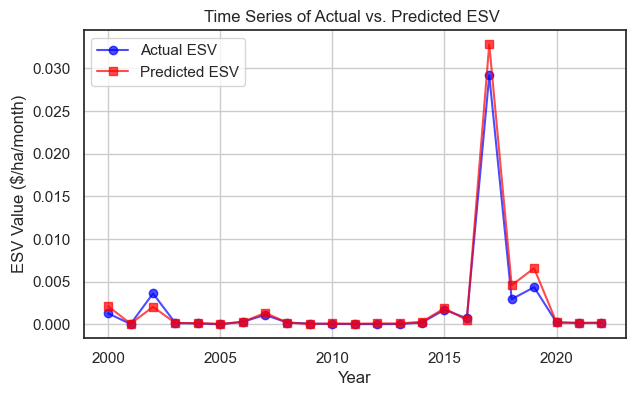

In [154]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure X_test contains valid year information
if "Present Value Year" in X_test.columns:
    years_test = X_test["Present Value Year"]
else:
    years_test = final_merged_df.loc[X_test.index, "year"]  # Fallback to Year_Pub if needed

# Create a DataFrame for plotting
results_df = pd.DataFrame({'Year': years_test, 'Actual ESV': y_test, 'Predicted ESV': y_pred})

# Aggregate by year to smooth the time series (using mean)
results_df = results_df.groupby("Year")[["Actual ESV", "Predicted ESV"]].mean().reset_index()

# Plot actual vs. predicted ESV values over time
plt.figure(figsize=(7, 4))
plt.plot(results_df["Year"], results_df["Actual ESV"], label="Actual ESV", marker='o', linestyle="-", color="blue", alpha=0.7)
plt.plot(results_df["Year"], results_df["Predicted ESV"], label="Predicted ESV", marker='s', linestyle="-", color="red", alpha=0.7)

# Labels and title
plt.xlabel("Year")
plt.ylabel("ESV Value ($/ha/month)")
plt.title("Time Series of Actual vs. Predicted ESV ")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()